In [ ]:
# ============================
# Imports
# ============================
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

# ============================
# Mount Google Drive
# ============================
from google.colab import drive
# لو سبق mount، ممكن تتجاهل السطر ده
drive.mount('/content/drive', force_remount=True)

# ============================
# Hyperparameters / Paths
# ============================
DATA_DIR = '/content/drive/MyDrive/Skeleton_Overlay/Type_03'  # <-- هنا فولدر Type_01
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_EPOCHS = 40
NUM_WORKERS = 2
IMAGE_SIZE = 224
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
RANDOM_SEED = 42

# ============================
# Preprocessing / Augmentation
# ============================
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# ============================
# Dataset Class
# ============================
class SkeletonOverlayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx])
        return img, label

# ============================
# Split dataset in memory
# ============================
def split_dataset_in_memory(root_dir):
    random.seed(RANDOM_SEED)
    train_paths, val_paths, test_paths = [], [], []
    train_labels, val_labels, test_labels = [], [], []

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        imgs = [os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.lower().endswith(('.png','.jpg','.jpeg'))]
        if len(imgs) == 0:
            print(f"تحذير: فولدر {class_name} فاضي!")
            continue
        random.shuffle(imgs)
        n_total = len(imgs)
        n_train = int(n_total * TRAIN_SPLIT)
        n_val   = int(n_total * VAL_SPLIT)

        train_paths += imgs[:n_train]
        val_paths   += imgs[n_train:n_train+n_val]
        test_paths  += imgs[n_train+n_val:]

        train_labels += [class_name] * n_train
        val_labels   += [class_name] * n_val
        test_labels  += [class_name] * (n_total - n_train - n_val)

    # تحويل أسماء الحروف لأرقام ثابتة
    le = LabelEncoder()
    train_labels = le.fit_transform(train_labels)
    val_labels   = le.transform(val_labels)
    test_labels  = le.transform(test_labels)

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

# ============================
# Main: قراءة البيانات وإنشاء DataLoaders
# ============================
(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = split_dataset_in_memory(DATA_DIR)

# تحقق من الصور وعددهم
print("Train images:", len(train_paths))
print("Val images:", len(val_paths))
print("Test images:", len(test_paths))

if len(train_paths) == 0 or len(val_paths) == 0 or len(test_paths) == 0:
    raise ValueError("واحد أو أكثر من Datasets فاضي! اتأكد من DATA_DIR والمسار للصور والفولدرات.")

train_dataset = SkeletonOverlayDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = SkeletonOverlayDataset(val_paths, val_labels, transform=val_transform)
test_dataset  = SkeletonOverlayDataset(test_paths, test_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Dataset split, read, and DataLoaders are ready!")


Mounted at /content/drive
Train images: 29400
Val images: 6300
Test images: 6300
Dataset split, read, and DataLoaders are ready!


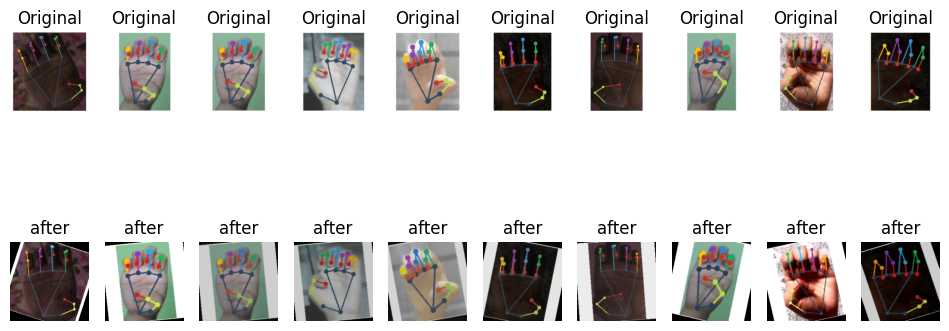

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# دالة لعرض الصور الأصلية و بعد الـ augmentation جنب بعض
def show_original_vs_augmented(dataset, n=5):
    plt.figure(figsize=(12,5))
    for i in range(n):
        # الصورة الأصلية
        orig_img_path = dataset.image_paths[i]
        orig_img = Image.open(orig_img_path).convert('RGB')

        # الصورة بعد التحويلات
        aug_img, label = dataset[i]
        aug_img_display = aug_img.permute(1,2,0) * 0.5 + 0.5  # عكس normalize

        # عرض الأصلية
        plt.subplot(2, n, i+1)
        plt.imshow(orig_img)
        plt.title("Original")
        plt.axis('off')

        # عرض بعد الـ augmentation
        plt.subplot(2, n, i+n+1)
        plt.imshow(aug_img_display)
        plt.title("after")
        plt.axis('off')
    plt.show()

# مثال على أول 5 صور من train_dataset
show_original_vs_augmented(train_dataset, n=10)
